In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from xgboost.sklearn import XGBClassifier
from catboost import CatBoostClassifier

import warnings
warnings.simplefilter("ignore")
%matplotlib inline

In [6]:
# load the raw data in a pandas dataframe
df_raw = pd.read_csv("./drinking_water_potability.csv")
df_raw

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890456,20791.31898,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.05786,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.54173,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.41744,8.059332,356.886136,363.266516,18.436525,100.341674,4.628771,0
4,9.092223,181.101509,17978.98634,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681736,47580.99160,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.80216,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.57822,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.86938,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1


In [7]:
# Check for missing data
df_raw.isna().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

39.01 % of samples are potable (1)


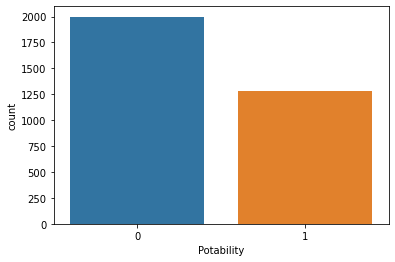

In [8]:
# view distribution
sns.countplot(x=df_raw["Potability"])

print(f'{df_raw.Potability[df_raw.Potability==1].count()/df_raw.Potability.count()*100:.2f} % of samples are potable (1)')

<AxesSubplot:>

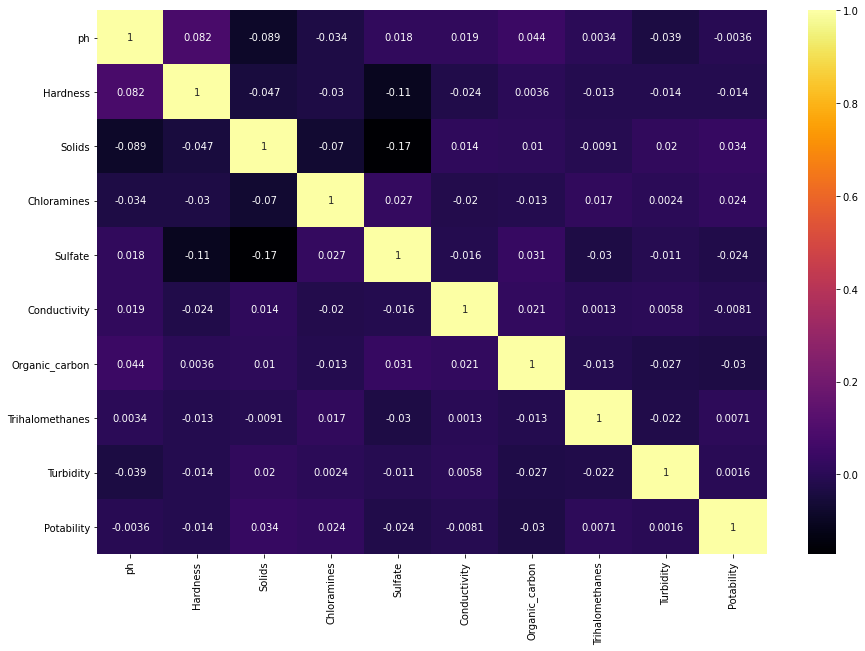

In [9]:
# Correlation matrix for dataset
plt.figure(figsize=(15,10))
sns.heatmap(df_raw.corr(), annot=True, cmap="inferno")

In [10]:
# Function to fill in missing data
def fill_nan(df):
    for index, column in enumerate(df.columns[:9]):
        # print(index, column)
        df[column] = df[column].fillna(df.groupby('Potability')[column].transform('mean'))
    return df
 

In [11]:
df = fill_nan(df_raw)

df.isna().sum() 

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

In [12]:
# Splitting
X = df.drop(['Potability'], axis = 1)
y = df['Potability']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=18, stratify=y) #stratify=y

# Balancing data - oversampling minority
smt = SMOTE()
X_train, y_train = smt.fit_resample(X_train, y_train)

# Scaling
sc = StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [13]:
# Put models in a dictionary
models = {"Logistic Regression": LogisticRegression(),
         "KNN": KNeighborsClassifier(),
         "Random Forest": RandomForestClassifier(),
         "Decision Tree": DecisionTreeClassifier(),
         "Naive Bayes": GaussianNB(),
         "ExtraTreesClassifier": ExtraTreesClassifier(),
         "xgb Classifier": XGBClassifier(),
         "CatBoostClassifier": CatBoostClassifier()}

In [15]:
# Function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
   
    """
   Fits and evaluates given machine learning models.
   models: a dict of different Scikit_Learn machine learning models
   X_train: training data (no labels)
   X_test: testing data (no labels)
   y_train: training labels
   y_test: test labels
   """ 
    # Set random seed
    np.random.seed(18)
    # Make a dictionary to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit model to data
        model.fit(X_train, y_train)
        # Evaluate model and append its score to model_scores
        model_scores[name] = cross_val_score(model,
                                             X_test,
                                             y_test,
                                            scoring='accuracy',
                                            cv=5
                                            ).mean()

    return model_scores

In [16]:
model_scores = fit_and_score(models,X_train,X_test,y_train,y_test)

model_scores

[15:16:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:16:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:16:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:16:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

{'Logistic Regression': 0.6129432889420918,
 'KNN': 0.6007107586413287,
 'Random Forest': 0.7777944037109082,
 'Decision Tree': 0.7301436480622474,
 'Naive Bayes': 0.6300613496932514,
 'ExtraTreesClassifier': 0.6691306299566063,
 'xgb Classifier': 0.7924435133921891,
 'CatBoostClassifier': 0.7887700134670058}

<AxesSubplot:>

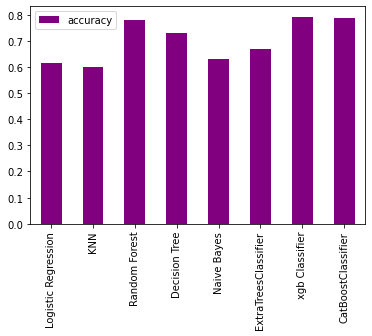

In [18]:
model_compare = pd.DataFrame(model_scores, index=["accuracy"])
model_compare.T.plot.bar(color="purple")